In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
%matplotlib inline

In [2]:
plt.style.use('seaborn-white')

In [3]:
url = '''https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'''
data = pd.read_csv(url)

In [4]:
url = 'https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv'
pop_data = pd.read_csv(url, encoding="Latin")

In [5]:
pop = pop_data[['STNAME','CTYNAME','POPESTIMATE2019']]
pop.rename(columns={'STNAME':'state', 
                    'CTYNAME':'county', 
                    'POPESTIMATE2019':'pop2019'}, inplace=True)

C:\Users\Jesse\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [6]:
pop = pop[pop['state']!=pop['county']] # Cut full states

In [7]:
# Remove 'County' from population dataframe
pop['county'] = pop['county'].str.replace(' County', '') 

In [8]:
df = pd.DataFrame(data)

In [9]:
df = pd.merge(df, pop) # Merge Covid data with population data

In [10]:
# Index by state, county, and date
df.set_index(['state', 'county', 'date'], inplace=True) 

In [11]:
df.sort_index(inplace=True)

In [12]:
# Add columns adjusting for population
df['cases_per_100k'] = df['cases'] * 100000/df['pop2019']
df['deaths_per_100k'] = df['deaths'] * 100000/df['pop2019']

In [13]:
# Create a function to calculate new cases and new deaths from running totals
def get_new_nums(array_of_nums):
    """Subtract previous days cases or deaths from current day"""
    new_nums = [0]  
    for i in range(len (array_of_nums) -1 ):
        new_count = array_of_nums[i + 1] - array_of_nums[i]
        if new_count <= 0:
            new_count = 0
        new_nums.append(new_count)
    return np.array(new_nums)

In [14]:
# Add columns for new cases and new deaths
df['new_cases'] = get_new_nums(df['cases'])
df['new_deaths'] = get_new_nums(df['deaths'])

In [15]:
# Add columns adjusting new deaths and new cases by population
df['new_cases_per_100k'] = df['new_cases'] * 100000/df['pop2019']
df['new_deaths_per_100k'] = df['new_deaths'] * 100000/df['pop2019']

In [16]:
# Create a simple function for graphing rolling values of features
def graph_rolling_stats(state, county, feature, style):
    '''Graphs the 7-day rolling mean of a given feature'''
    ax.plot(pd.to_datetime(df.loc[state, county].index.values), # Dates as x vals
    df.loc[state, county][feature].rolling(7).mean(), style) # Features as y vals

In [17]:
# Create list of counties in Oregon Healthcare Preparedness Region 1
counties = ['Clatsop', 'Clackamas', 'Columbia', 
            'Multnomah', 'Washington', 'Tillamook']
styles = [':g', ':r', ':c', 
          '-g', '-r', '-c'] # One style per county

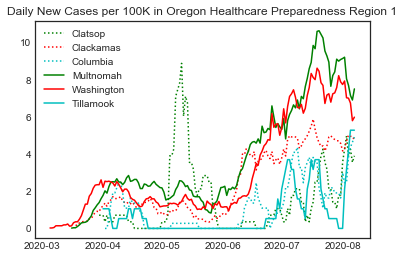

In [18]:
# Graph new cases weighted by population
fig = plt.figure()
ax = plt.axes()
for i in range(len(counties)):
    graph_rolling_stats('Oregon', counties[i], 'new_cases_per_100k', styles[i])
ax.set(title='Daily New Cases per 100K in Oregon Healthcare Preparedness Region 1')
ax.legend(counties);

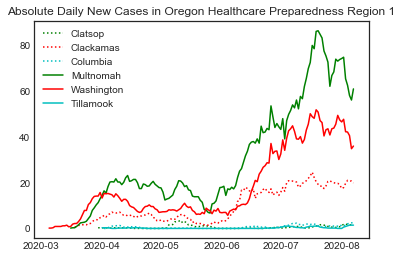

In [19]:
# Graph absolute new cases
fig = plt.figure()
ax = plt.axes()
for i in range(len(counties)):
    graph_rolling_stats('Oregon', counties[i], 'new_cases', styles[i])
ax.set(title='Absolute Daily New Cases in Oregon Healthcare Preparedness Region 1')
ax.legend(counties);